In [1]:
import sounddevice as sd
import matplotlib.pyplot as plt

from synthoor import GatedSound, Envelope, Oscillator, LatencyGate, ButterFilter
%load_ext autoreload
%autoreload 2

### Oscillator

In [2]:
osc0 = Oscillator('sine')
osc_play = osc0(freq = 200)
sd.play(osc_play)

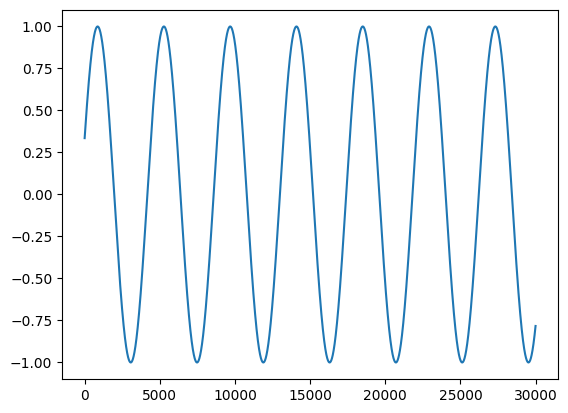

In [3]:
plt.plot(osc0(freq = 10))

### Frequency Modulation

In [4]:
modulate_osc = osc0(freq=5)
osc1 = Oscillator('sine')
modulated_osc = osc1(modulate_osc, freq=300)
sd.play(modulated_osc)

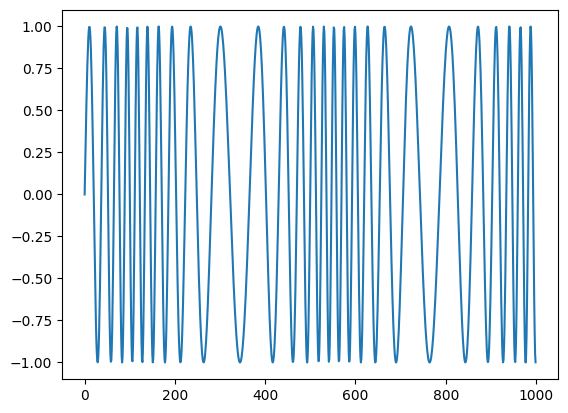

In [5]:
osc0 = Oscillator('sine', 100)
osc1 = Oscillator('sine', 1000)
a0 = osc0() * 12
a1 = osc1(a0)
plt.plot(a1[:1000])

### ASDR Envelope

In [6]:
frames = 50000
gate = LatencyGate()
osc_sine = osc0(
    freq = 300,
    frames=frames
)
asdr = Envelope(
    attack=0.4, 
    decay=0.1,
    sustain=0.5,
    release=0.5
)
gate.open(dt=0.1)
gate.close(dt=0.5)
g0 = gate(frames=frames)
enveloped_wave = osc_sine * asdr(g0)
sd.play(enveloped_wave)

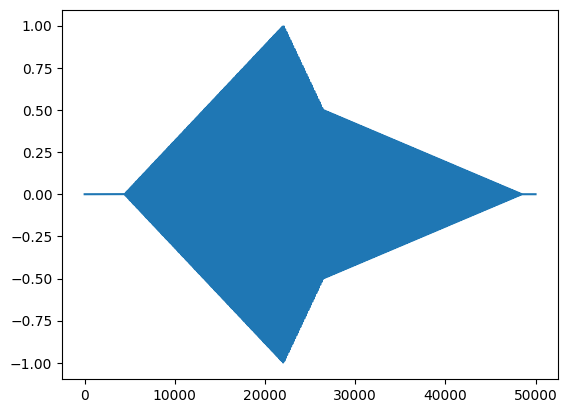

In [7]:
plt.plot(enveloped_wave)

### Butter Filter
The Butterworth filter is a type of signal processing filter designed to have a frequency response that is as flat as possible in the passband. It is also referred to as a maximally flat magnitude filter. It is based on the notion that 

> **An ideal electrical filter should not only completely reject the unwanted frequencies but should also have uniform sensitivity for the wanted frequencies**

In [28]:
osc_sine = osc0(
    freq = 600,
)
bfilter = ButterFilter(
    freq=200,
    btype='lowpass'
)
filtered_wave = bfilter(osc_sine)
sd.play(filtered_wave)

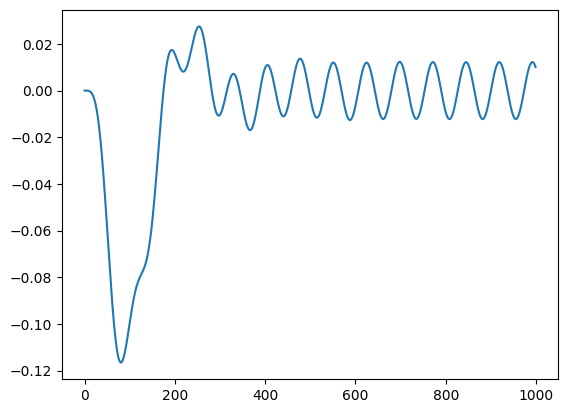

In [29]:
plt.plot(filtered_wave[:1000])

### Building Synthesizers

In [30]:
class SimpleSynth(GatedSound):

    def __init__(self):

        super().__init__()

        self.osc0 = Oscillator('sine')

    def forward(self):
        
        g0 = self.gate()
        a0 = self.osc0()

        return a0 * g0

s = SimpleSynth()
s.play(
    duration=0.5
)

### TB303: Acid Synth

In [40]:
class TB303(GatedSound):

    def __init__(self):

        super().__init__()

        self.env0 = Envelope(0.05, 0., 1., 0.01)
        self.env1 = Envelope(0., 1., 0., 0., linear=False)

        self.osc0 = Oscillator('saw')

        self.filter = ButterFilter(btype='lowpass')

    def forward(self):

        g0 = self.gate()

        e0 = self.env0(g0)
        e1 = self.env1(g0, decay=1) * 12 * 10

        a0 = self.osc0(freq=self.freq)

        a1 = self.filter(
            a0,
            key_modulation=e1,
            freq=self.freq,
        )

        return a1 * e0
    
t = TB303()
t.play(
    duration=1
)